<a href="https://colab.research.google.com/github/kkwakkwaks/Abandoned-cat-adoption-prediction-model/blob/main/Section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 선정 이유 및 문제 정의


## 데이터 불러오기

In [ ]:
from google.colab import files

file = files.upload()

Saving Austin_Animal_Center_Outcomes_Cat.csv to Austin_Animal_Center_Outcomes_Cat (1).csv


In [ ]:
import sys
import xgboost
import warnings

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

warnings.filterwarnings("ignore")

#### 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from pdpbox import pdp

In [ ]:
outcomes = pd.read_csv('Austin_Animal_Center_Outcomes_Cat.csv')

In [ ]:
outcomes.shape

(52928, 12)

In [ ]:
df = outcomes.drop_duplicates(subset='Animal ID', keep='first')

df.shape   # animal id가 중복인 값 제거

(50467, 12)

## 데이터 확인
### '2013-10-01' ~ '2022-05-19' 까지의 Austin Animal Center의 유기묘 data
#### 상황 
- 유기동물 보호소의 직원으로서 입양을 잘 가지 못하는 고양이들을 미리 예측하여 입양을 갈 수 있도록 돕는 것이 목표

#### 타겟 
- Outcome Type(결과 유형 : 입양 여부)
- columns
        Animal ID : 동물의 고유 id
        Name : 동물의 이름
            (이름 여부로 분류할 것)
        DateTime : 동물 발견 날짜
        MonthYear : 동물 발견 연월
        Date of Birth : 동물의 출생일
        Outcome Type : 결과 유형
            - Transfer : 다른 곳으로 이동
            - Adoption : 입양
            - Euthanasia : 안락사
            - Return to Owner : 귀가
            - Died : 사망
            - Rto-Adopt : 아마도 귀가
            - Missing : 실종
            - Disposal : 아마도 사망

        Outcome Subtype : 결과 하위 유형
            - Transfer
                * Partner
                * Out State
                * In State
                * Emer
            - Adoption
                * Foster 
                * Offsite
            - Euthanasia
                * At Vet 
                * Behavior
                * Medical  
                * Suffering     
                * Aggressive         
                * Court/Investigation   
                * Rabies Risk     
            - Return to Owner
                * Foster
                * Customer S    
                * Prc               
                * Field            
            - Died
                * In Kennel          
                * In Foster           
                * Enroute             
                * In Surgery           
                * Emergency           
                * At Vet   
            - Rto-Adopt
            - Missing
                * In Kennel
                * In Foster
                * Possible Theft       
            - Disposal
     
        Animal Type : 동물 유형(모두 cat)
        Sex upon Outcome : 동물 성별(중성화여부 포함)
            - Neutered Male : 중성화 한 수컷
            - Spayed Female : 중성화 한 암컷
            - Intact Male : 중성화 하지 않은 수컷
            - Intact Female : 중성화 하지 않은 암컷
            - Unknown : 성별 미상
        Age upon Outcome : 발견 당시 동물의 나이
        Breed : 동물의 품종
        Color : 동물의 색

#### 가설
- 나이가 어릴수록 입양을 더 잘 갈 것이다.
- 성별은 입양 여부와 관계 없을 것이다.
- 시간이 지날수록 입양률이 높아질 것이다.
- 이름의 여부는 입양률과 상관 없을 것이다.

In [ ]:
df.head().T

,0,1,2,3,4
Animal ID,A794011,A674754,A689724,A680969,A684617
Name,Chunk,NaN,*Donatello,*Zeus,NaN
DateTime,05/08/2019 06:20:00 PM,03/18/2014 11:47:00 AM,10/18/2014 06:52:00 PM,08/05/2014 04:59:00 PM,07/27/2014 09:00:00 AM
MonthYear,May 2019,Mar 2014,Oct 2014,Aug 2014,Jul 2014
Date of Birth,05/02/2017,03/12/2014,08/01/2014,06/03/2014,07/26/2012
Outcome Type,Rto-Adopt,Transfer,Adoption,Adoption,Transfer
Outcome Subtype,NaN,Partner,NaN,NaN,SCRP
Animal Type,Cat,Cat,Cat,Cat,Cat
Sex upon Outcome,Neutered Male,Intact Male,Neutered Male,Neutered Male,Intact Female
Age upon Outcome,2 years,6 days,2 months,2 months,2 years


###### 전체 결측치

In [ ]:
df.isnull().sum()

# Name 은 결측치 여부로 판단할 것이라서 문제 x
# Outcome Subtype 는 대부분 입양가지 못 한 고양이에게만 값이 있으므로 제거

Animal ID               0
Name                21632
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            4
Outcome Subtype     18955
Animal Type             0
Sex upon Outcome        0
Age upon Outcome        0
Breed                   0
Color                   0
dtype: int64

In [ ]:
# Outcome Type이 결측치인 행 제거
df = df.dropna(subset=['Outcome Type'])
# Sex upon Outcome 'unknown'값 제거
unknown = df['Sex upon Outcome'].isin(['Unknown'])
df = df[~unknown]
df.shape

(46377, 12)

In [ ]:
df.nunique()

Animal ID           46377
Name                12479
DateTime            36951
MonthYear             104
Date of Birth        5908
Outcome Type            9
Outcome Subtype        21
Animal Type             1
Sex upon Outcome        4
Age upon Outcome       45
Breed                 104
Color                 280
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46377 entries, 0 to 52927
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Animal ID         46377 non-null  object
 1   Name              28628 non-null  object
 2   DateTime          46377 non-null  object
 3   MonthYear         46377 non-null  object
 4   Date of Birth     46377 non-null  object
 5   Outcome Type      46377 non-null  object
 6   Outcome Subtype   27532 non-null  object
 7   Animal Type       46377 non-null  object
 8   Sex upon Outcome  46377 non-null  object
 9   Age upon Outcome  46377 non-null  object
 10  Breed             46377 non-null  object
 11  Color             46377 non-null  object
dtypes: object(12)
memory usage: 4.6+ MB


-missing, died, relocate 등의 결과는 예측이 어려움

-따라서 Adoption, Return to Owner, Rto_Adopt 이 셋을 입양완료(1)라 생각하고 분류 문제로 설정

In [ ]:
df['Outcome Type'].value_counts()

Adoption           23548
Transfer           18050
Return to Owner     2112
Euthanasia          1770
Died                 643
Rto-Adopt            169
Disposal              51
Missing               30
Relocate               4
Name: Outcome Type, dtype: int64

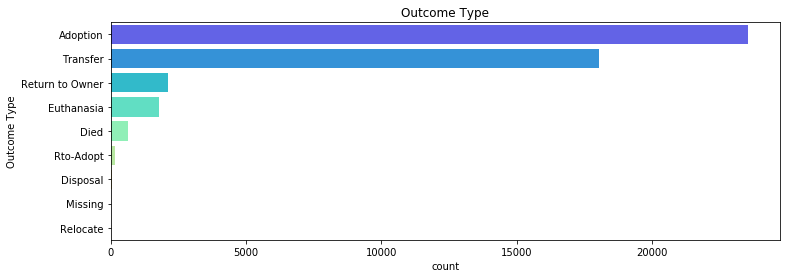

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(y=df['Outcome Type'], 
              palette='rainbow',
              order=df['Outcome Type'].value_counts().index)
plt.title('Outcome Type')
plt.show()

In [ ]:
# target 변수 생성

def adopt(df):
    result=[]

    for row in df['Outcome Type']:
        if 'Adoption' in row or 'Return to Owner' in row or 'Rto-Adopt' in row:
            result.append(1)
        else:
            result.append(0)  

    df['Adopt'] = result

    return df


adopt(df)
df['Adopt'].value_counts()

1    25829
0    20548
Name: Adopt, dtype: int64

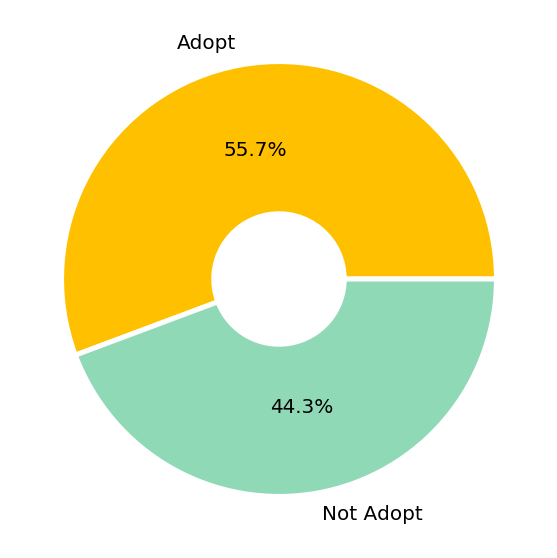

In [ ]:
# '#ff9999','#ffc000','#8fd9b6','#d395d0'
plt.figure(figsize=(10,10))
plt.pie(df['Adopt'].value_counts(), labels=['Adopt','Not Adopt'],  autopct='%.1f%%', 
        colors=['#ffc000','#8fd9b6'],textprops={'size': 20},
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.show()

# 데이터에 불균형이 없어보임

### feature engineering

In [ ]:
# Name을 이름의 여부를 알려주는 분류 feature로 변경 (이름 있으면 1, 없으면 0)
df['Name'] = df['Name'].notnull()
df['Name'] = df['Name'].astype(int)
df['Name'].value_counts()

1    28628
0    17749
Name: Name, dtype: int64

In [ ]:
# datetime 형식으로 바꿔줌
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'])
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [ ]:
# days로 나이 계산
df['Age_days'] = df['DateTime'] - df['Date of Birth']
df['Age_days'] = df['Age_days'].dt.days

In [ ]:
# 년수로 나이 계산
df['Age_years'] = df['Age_days'] / 365

In [ ]:
df['Date of Birth'] = pd.to_datetime(df['Date of Birth']).dt.strftime("%Y-%m-%d")
df['DateTime'] = pd.to_datetime(df['DateTime']).dt.strftime("%Y-%m-%d")
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'])
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [ ]:
# 생후 6주 이내 : Neonatal(신생)
# 생후 6주 이후 1년 이내 : Kitten , 1살 이상 : Adult

def Kitten(df):
    result=[]

    for row in df['Age_days']:
        if row <= 42:
            result.append('Neonatal')
        elif row > 42 and row < 365:
            result.append('Kitten')
        else:
            result.append('Adult')  

    df['Cat/Kitten/Neonatal'] = result

    return df


Kitten(df)
df['Cat/Kitten/Neonatal'].value_counts()

Kitten      23981
Adult       15762
Neonatal     6634
Name: Cat/Kitten/Neonatal, dtype: int64

##### Neonatal 그래프

In [ ]:
Neonatal = pd.DataFrame(df.loc[df['Cat/Kitten/Neonatal'] == 'Neonatal']['Outcome Type'].value_counts()).T
Neonatal

,Transfer,Euthanasia,Died,Return to Owner,Disposal,Adoption,Rto-Adopt,Missing
Outcome Type,6125,240,223,27,9,6,2,2


In [ ]:
# # Neonatal인 고양이들의 입양률이 낮은 이유는 거의 다 Transfer(양육장으로 옮겨짐) 됐기 때문
# # -> 한계점으로 설정

# plt.figure(figsize=(10,10))
# plt.pie(Neonatal,
#         labels=['Transfer','Euthanasia','Died','Etc'],
#         autopct='%.1f%%', 
#         colors=['#ffc000','#8fd9b6','#d395d0','#ff9999'],textprops={'size': 20}, explode = [0.2, 0, 0, 0],
#         wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
# plt.show()



In [ ]:
# Neonatal_trans = df[['Cat/Kitten/Neonatal','Outcome Type','Outcome Subtype']]
# Neonatal_trans = Neonatal_trans.loc[df['Cat/Kitten/Neonatal'] == 'Neonatal']
# Neonatal_trans.loc[Neonatal_trans['Outcome Type'] == 'Transfer']['Outcome Subtype'].value_counts()

In [ ]:
df['Sex upon Outcome'].value_counts()

Neutered Male    15082
Spayed Female    15053
Intact Female     8521
Intact Male       7721
Name: Sex upon Outcome, dtype: int64

In [ ]:
#성별
df['Sex'] = np.where(df['Sex upon Outcome'].str.contains('Male'), 'Male', 'Female')
df['Sex'].value_counts()

Female    23574
Male      22803
Name: Sex, dtype: int64

In [ ]:
#중성화여부
df['Neutering'] = np.where(df['Sex upon Outcome'].str.contains('Intact'), '0', '1')
df['Neutering'].value_counts()

1    30135
0    16242
Name: Neutering, dtype: int64

In [ ]:
df['Breed'] = df['Breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [ ]:
# cfa에 등록된 고양이 품종 목록
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [ ]:
# 두 가지 종이 섞인 거 분류
df = pd.concat([df, df['Breed'].str.split('/', expand=True).rename(columns={0:'Breed1', 1:'Breed2'})], axis=1)

# cfa_breeds 에 있는 종인지 확인
# 둘 중 하나가 cfa_breeds에 속하면 true, 아니면 false
df['cfa_breed'] = np.where((df['Breed1'].str.contains(cfa_breeds)) | 
                                (df['Breed2'].str.contains(cfa_breeds)), 
                                1, 0)


In [ ]:
print(df['cfa_breed'].value_counts(),'\n')

0    43952
1     2425
Name: cfa_breed, dtype: int64 



In [ ]:
# 코트 패턴 목록
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

coat_reg = '(' + '|'.join(coat_patterns) + ')'

df['Color'] = df['Color'].str.lower()

# 패턴만 분류
df['coat_pattern'] = df['Color'].str.extract(coat_reg, expand=False)

# 패턴을 제외한 색만 분류
df['Color'] = df['Color'].str.replace(coat_reg, '').str.strip()
df['Color'] = df['Color'].str.replace(' ', '').str.strip()
df['Color'] = df['Color'].str.replace('/', '').str.strip()

In [ ]:
df['Color'].nunique()

141

In [ ]:
# 패턴의 유무
df['pattern'] = df['coat_pattern'].notnull()
df['pattern'].value_counts()

True     30508
False    15869
Name: pattern, dtype: int64

In [ ]:
# 패턴이 없는 고양이는 'no pattern'으로 분류
df['coat_pattern'] = df['coat_pattern'].fillna('no pattern')

In [ ]:
# 패턴의 유무
df['pattern'] = df['pattern'].replace(False,0).replace(True,1)

In [ ]:
# engineering 한 feature와 필요없는 feature 삭제
# 'Color'는 cardinality가 141이라서 삭제
df_cat = df.drop(['Animal ID','DateTime','MonthYear','Date of Birth','Outcome Subtype',
         'Animal Type','Age upon Outcome','Breed','Breed1','Breed2','Color','Age_years'],axis=1)

df_cat.head()

,Name,Outcome Type,Sex upon Outcome,Adopt,Age_days,Cat/Kitten/Neonatal,Sex,Neutering,cfa_breed,coat_pattern,pattern
0,1,Rto-Adopt,Neutered Male,1,736,Adult,Male,1,0,tabby,1
1,0,Transfer,Intact Male,0,6,Neonatal,Male,0,0,tabby,1
2,1,Adoption,Neutered Male,1,78,Kitten,Male,1,0,no pattern,0
3,1,Adoption,Neutered Male,1,63,Kitten,Male,1,0,tabby,1
4,0,Transfer,Intact Female,0,731,Adult,Female,0,0,no pattern,0


In [ ]:
df_cat.isnull().sum()

Name                   0
Outcome Type           0
Sex upon Outcome       0
Adopt                  0
Age_days               0
Cat/Kitten/Neonatal    0
Sex                    0
Neutering              0
cfa_breed              0
coat_pattern           0
pattern                0
dtype: int64

## 최종 데이터
- Name : 이름의 여부 (있으면 1, 없으면 0)
- Age_days : 고양이의 나이(days)
- Age_months : 고양이의 나이(개월)
- Age_years : 고양이 나이
- Cat/Kitten/Neonatal	 : cat/Kitten/n
- Sex
- Neutering
- cfa_breed
- coat_pattern	
- pattern	
- Years	
- Adopt

In [ ]:
df_cat['Adopt'].value_counts(normalize=True)

1    0.556936
0    0.443064
Name: Adopt, dtype: float64

###### train/test set 나누기
* K Fold 사용

In [ ]:
train, test = train_test_split(df_cat, test_size=0.2, random_state=2)

train.shape, test.shape

((37101, 11), (9276, 11))

In [ ]:
target = 'Adopt'
features = train.columns.drop([target])

# 나중에 outcomtype이 시각화에 쓰여서 outcometype을 포함하는 데이터 생성
X_train1 = train[features]
y_train = train[target]

X_test1 = test[features]
y_test = test[target]

In [ ]:
def drop_outcometype(df):
    df = df.drop(['Outcome Type'],axis=1)

    return df

# outcometype이 있으면 데이터리키지 발생하니까 삭제
X_train = drop_outcometype(X_train1)
X_test = drop_outcometype(X_test1)

In [ ]:
print(X_train.columns)
print(X_test.columns)

Index(['Name', 'Sex upon Outcome', 'Age_days', 'Cat/Kitten/Neonatal', 'Sex',
       'Neutering', 'cfa_breed', 'coat_pattern', 'pattern'],
      dtype='object')
Index(['Name', 'Sex upon Outcome', 'Age_days', 'Cat/Kitten/Neonatal', 'Sex',
       'Neutering', 'cfa_breed', 'coat_pattern', 'pattern'],
      dtype='object')


In [ ]:
X_train.shape

(37101, 9)

In [ ]:
major = y_train.mode()[0]
print(y_train.value_counts(normalize=True))
# 기준모델 설정
y_pred = [major] * len(y_train)

1    0.559392
0    0.440608
Name: Adopt, dtype: float64


#### modeling

#### RandomForest

##### TargetEncoder

In [ ]:
# TargetEncoder
pipe_tg = make_pipeline(

    TargetEncoder(),
    RandomForestClassifier(random_state=2))

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.],
    'targetencoder__min_samples_leaf': randint(1, 10),
    'randomforestclassifier__n_estimators' : randint(10, 1000),
    'randomforestclassifier__max_depth' : [5, 10, 15, 20, 25, 30],
    'randomforestclassifier__min_samples_leaf' : randint(10, 50),
    'randomforestclassifier__max_features' : uniform(0, 1)
}


clf_tg = RandomizedSearchCV(
    pipe_tg, 
    param_distributions=dists, 
    n_iter=50,
    cv=3,
    scoring='precision',
    verbose=1,
    n_jobs=-1
)

clf_tg.fit(X_train, y_train);

print('최적 하이퍼파라미터: ', clf_tg.best_params_)
print('precision: ', clf_tg.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.24817990232499842, 'randomforestclassifier__min_samples_leaf': 48, 'randomforestclassifier__n_estimators': 507, 'targetencoder__min_samples_leaf': 2, 'targetencoder__smoothing': 60.0}
precision:  0.8554179414031546


#### XGBboost

##### TargetEncoder

In [ ]:
pipe_tg_xgb = make_pipeline(
    TargetEncoder(),
    XGBClassifier(random_state=2
                 )
)

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], 
    'targetencoder__min_samples_leaf': randint(1, 10),     
    'xgbclassifier__n_estimators' : randint(10, 1000),
    'xgbclassifier__max_depth' : [5, 10, 15, 20, 25, 30],
    'xgbclassifier__learning_rate': uniform(0, 1)
}

clf_tg_xgb = RandomizedSearchCV(
    pipe_tg_xgb, 
    param_distributions=dists, 
    n_iter=50,
    cv=3,
    scoring='precision',
    verbose=1,
    n_jobs=-1
)

clf_tg_xgb.fit(X_train, y_train);

print('최적 하이퍼파라미터: ', clf_tg_xgb.best_params_)
print('precision: ', clf_tg_xgb.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 하이퍼파라미터:  {'targetencoder__min_samples_leaf': 5, 'targetencoder__smoothing': 500.0, 'xgbclassifier__learning_rate': 0.6742807218765622, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 658}
precision:  0.8501357756990112


#### Feature Importance

In [ ]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe = clf_tg.best_estimator_
pipe.fit(X_train, y_train)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Sex upon Outcome', 'Cat/Kitten/Neonatal',
                                     'Sex', 'Neutering', 'coat_pattern'],
                               min_samples_leaf=2, smoothing=60.0)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5,
                                        max_features=0.24817990232499842,
                                        min_samples_leaf=48, n_estimators=507,
                                        random_state=2))])

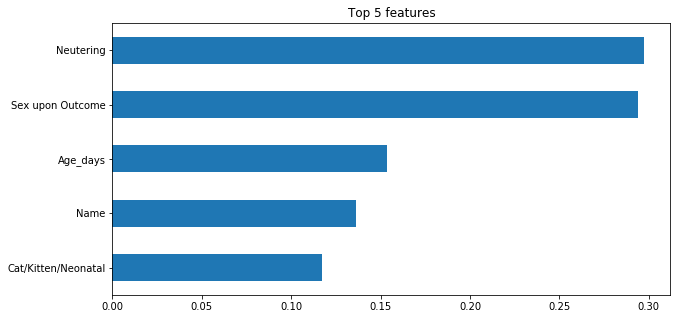

In [ ]:
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title('Top 5 features')
importances.sort_values()[-5:].plot.barh();

In [ ]:
importances.sort_values(ascending=False)

Neutering              0.297243
Sex upon Outcome       0.294223
Age_days               0.153452
Name                   0.136292
Cat/Kitten/Neonatal    0.117020
coat_pattern           0.000727
pattern                0.000396
Sex                    0.000342
cfa_breed              0.000304
dtype: float64

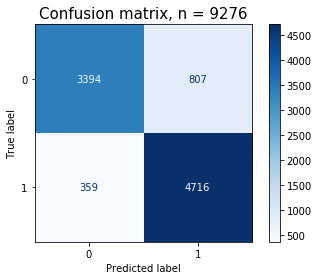

In [ ]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_test, y_test,
                            cmap=plt.cm.Blues,
                            ax=ax)
plt.title(f'Confusion matrix, n = {len(y_test)}', fontsize=15)
plt.show()

In [ ]:
y_pred = pipe.predict(X_test)
print('검증 정확도: ', accuracy_score(y_test, y_pred))

검증 정확도:  0.8742992669253988


In [ ]:
print(classification_report(y_test, y_pred))

# 정밀도(precision)이 중요 (입양 못 갈 고양이를 간다고 예측하면 안되기 때문)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      4201
           1       0.85      0.93      0.89      5075

    accuracy                           0.87      9276
   macro avg       0.88      0.87      0.87      9276
weighted avg       0.88      0.87      0.87      9276



#### 순열중요도

In [ ]:
pipe.named_steps

{'randomforestclassifier': RandomForestClassifier(max_depth=5, max_features=0.24817990232499842,
                        min_samples_leaf=48, n_estimators=507, random_state=2),
 'targetencoder': TargetEncoder(cols=['Sex upon Outcome', 'Cat/Kitten/Neonatal', 'Sex',
                     'Neutering', 'coat_pattern'],
               min_samples_leaf=2, smoothing=60.0)}

In [ ]:
# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['randomforestclassifier'], # model
    scoring='precision', # metric
    n_iter=100,
    random_state=2
)

# permuter 계산은 preprocessing 된 X_test을 사용합니다.
X_test_transformed = pipe.named_steps['targetencoder'].transform(X_test)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_transformed, y_test);

In [ ]:
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=X_test.columns.tolist() # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0239 ± 0.0023,Cat/Kitten/Neonatal
0.0233 ± 0.0050,Neutering
0.0215 ± 0.0026,Age_days
0.0156 ± 0.0050,Sex upon Outcome
0.0141 ± 0.0047,Name
0 ± 0.0000,pattern
0 ± 0.0000,coat_pattern
0 ± 0.0000,cfa_breed
0 ± 0.0000,Sex


#### PDP plot

##### 1 feature

In [ ]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

encoder = pipe.named_steps['targetencoder']
X_encoded = encoder.transform(X_test)
rf = pipe.named_steps['randomforestclassifier']

###### encoding 비교

In [ ]:
X_test['Cat/Kitten/Neonatal'].value_counts()

Kitten      4815
Adult       3106
Neonatal    1355
Name: Cat/Kitten/Neonatal, dtype: int64

In [ ]:
X_encoded['Cat/Kitten/Neonatal'].value_counts()	

0.756235    4815
0.492652    3106
0.004736    1355
Name: Cat/Kitten/Neonatal, dtype: int64

###### Cat/Kitten/Neonatal

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


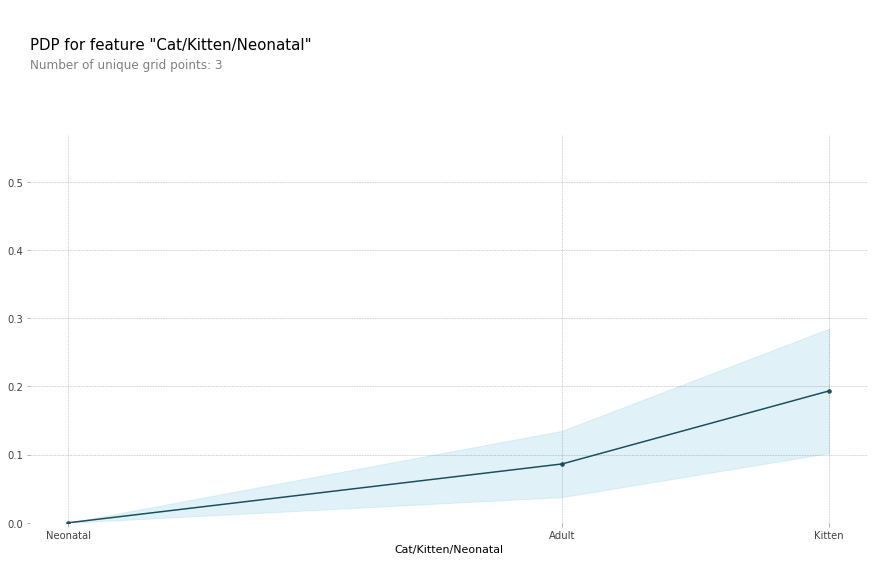

In [ ]:
feature = 'Cat/Kitten/Neonatal'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=X_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

plt.xticks([0.756235, 0.492652, 0.004736], 
           ['Kitten','Adult','Neonatal']); # 인코딩된 sex 값을 확인할 수 있습니다

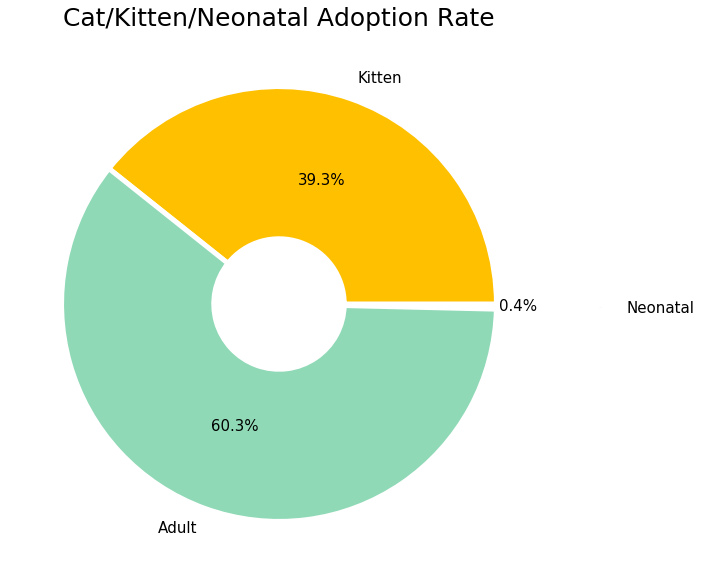

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(train.groupby('Cat/Kitten/Neonatal')['Adopt'].mean(), labels=['Kitten','Adult','Neonatal'],  autopct='%.1f%%', 
        colors=['#ffc000','#8fd9b6','#d395d0'],textprops={'size': 15},explode = [0, 0, 0.50],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.title('Cat/Kitten/Neonatal Adoption Rate',fontsize=25)
plt.show()

In [ ]:
Neonatal = pd.DataFrame(X_train1.loc[X_train1['Cat/Kitten/Neonatal'] == 'Neonatal']['Outcome Type'].value_counts()).T
Neonatal

,Transfer,Euthanasia,Died,Return to Owner,Disposal,Adoption,Missing,Rto-Adopt
Outcome Type,4861,194,189,19,8,4,2,2


In [ ]:
Neonatal['Etc'] = 35
Neonatal=Neonatal.drop(['Return to Owner','Disposal','Adoption','Missing', 'Rto-Adopt'],axis=1)
Neonatal

,Transfer,Euthanasia,Died,Etc
Outcome Type,4861,194,189,35


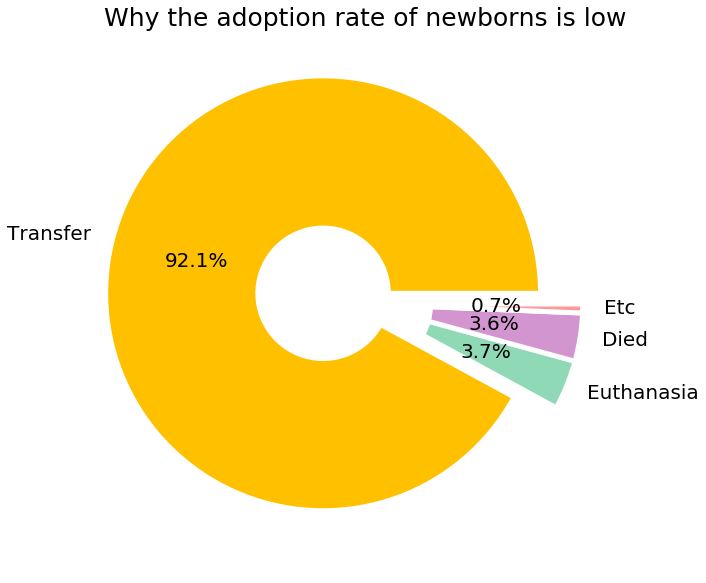

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(Neonatal,
        labels=['Transfer','Euthanasia','Died','Etc'],
        autopct='%.1f%%', 
        colors=['#ffc000','#8fd9b6','#d395d0','#ff9999'],textprops={'size': 20}, explode = [0.2, 0, 0, 0],
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.title('Why the adoption rate of newborns is low',fontsize=25)
plt.show()

###### Sex

In [ ]:
print(X_test['cfa_breed'].value_counts())
print(X_encoded['cfa_breed'].value_counts())

0    8813
1     463
Name: cfa_breed, dtype: int64
0    8813
1     463
Name: cfa_breed, dtype: int64


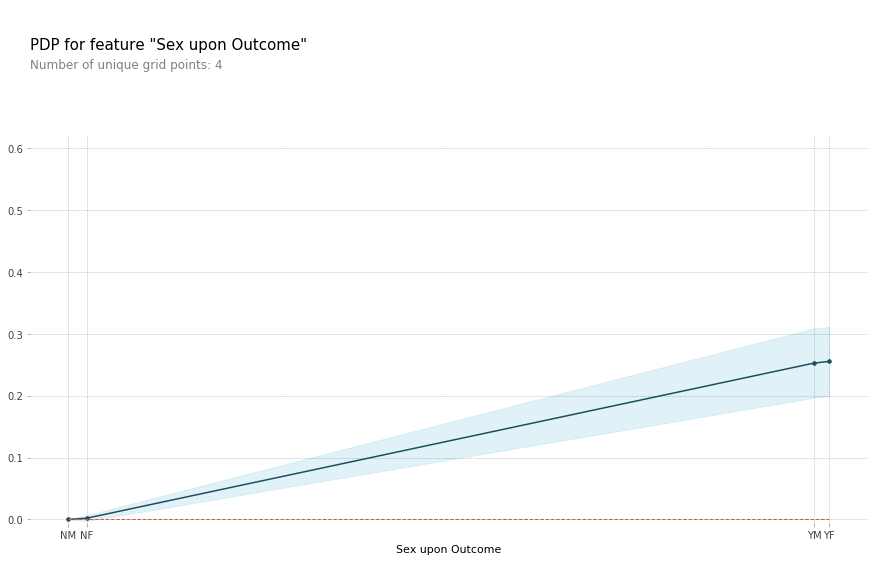

In [ ]:
feature = 'Sex upon Outcome'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=X_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

plt.xticks([0.817903, 0.803238, 0.096256, 0.078271], 
           ['YF','YM','NF','NM']); 

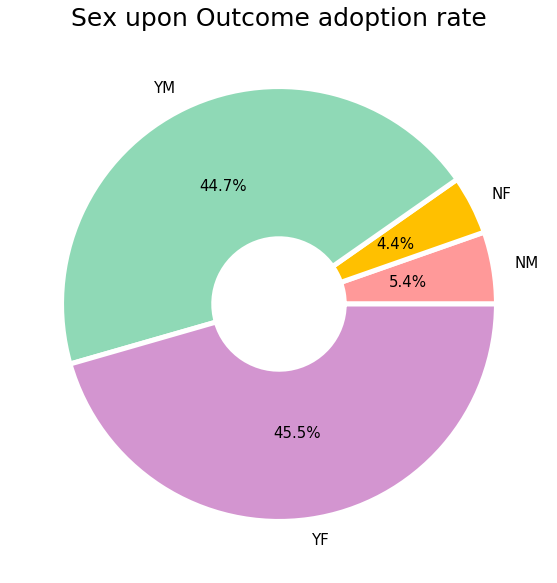

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(train.groupby('Sex upon Outcome')['Adopt'].mean(), labels=['NM','NF','YM','YF'],  autopct='%.1f%%', 
        colors=['#ff9999','#ffc000','#8fd9b6','#d395d0'],textprops={'size': 15},
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.title('Sex upon Outcome adoption rate',fontsize=25)
plt.show()

###### Name

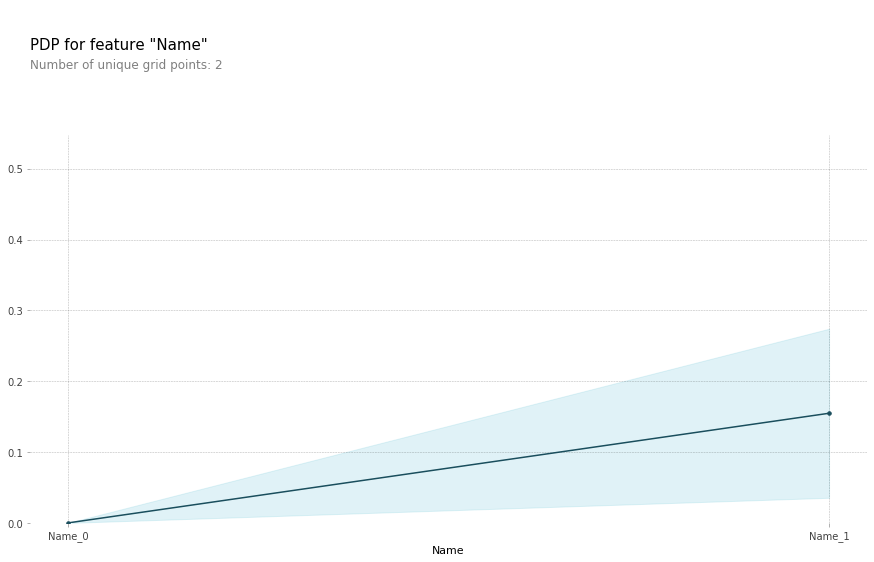

In [ ]:
feature = 'Name'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=X_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature); # 인코딩된 sex 값을 확인할 수 있습니다

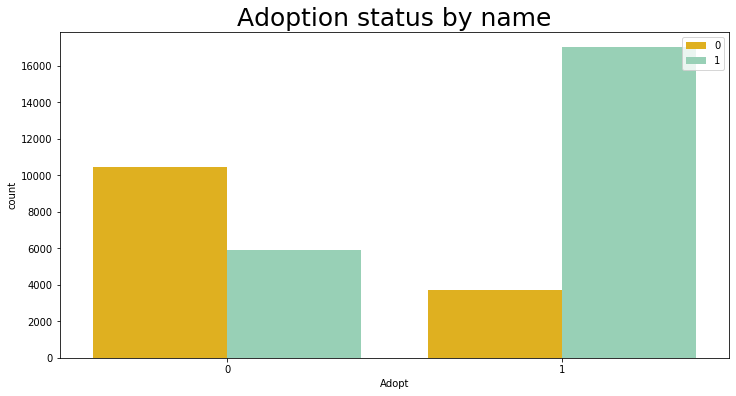

In [ ]:
# 이름에 따른 입양 여부를 보면 
colors=['#ffc000','#8fd9b6']
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(12,6))
plt.title('Adoption status by name',fontsize=25)
sns.countplot(data=train,x='Adopt',hue='Name')
plt.legend(loc='upper right')
plt.show()

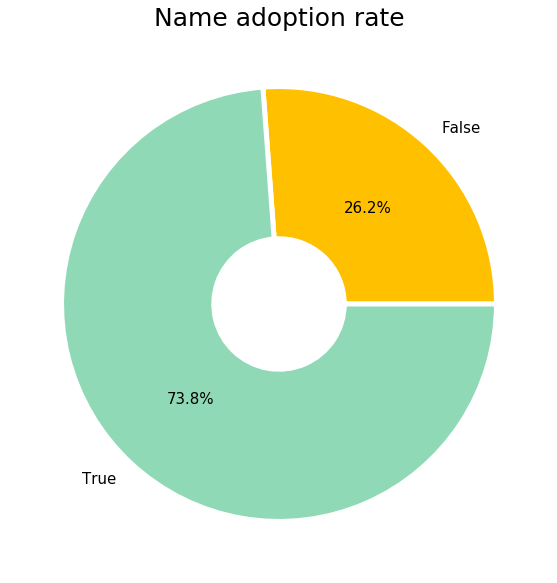

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(train.groupby('Name')['Adopt'].mean(), labels=['False','True'],  autopct='%.1f%%', 
        colors=['#ffc000','#8fd9b6'],textprops={'size': 15},
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.title('Name adoption rate',fontsize=25)
plt.show()

###### Breed

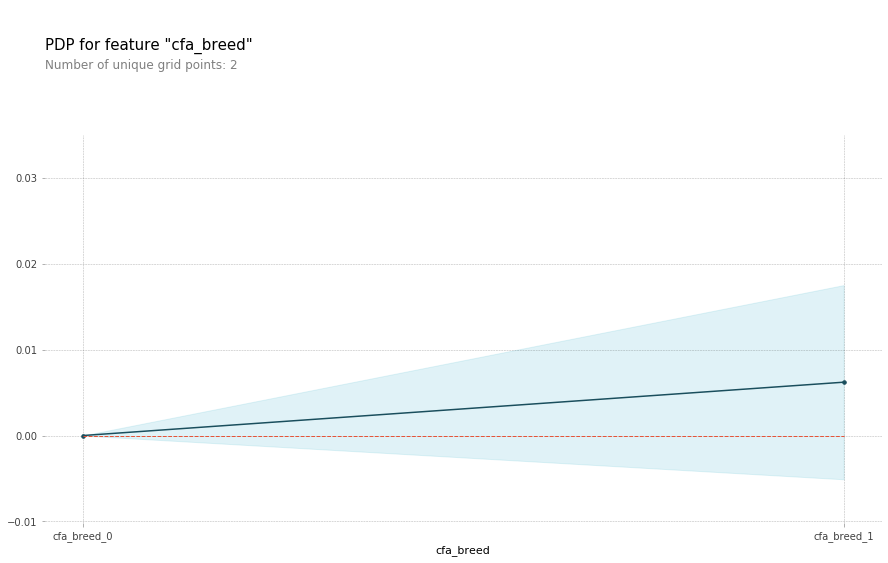

In [ ]:
feature = 'cfa_breed'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=X_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

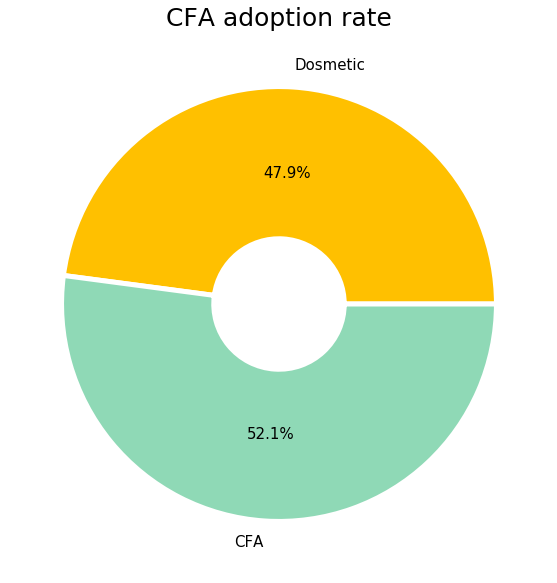

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(train.groupby('cfa_breed')['Adopt'].mean(), labels=['Dosmetic','CFA'],  autopct='%.1f%%', 
        colors=['#ffc000','#8fd9b6'],textprops={'size': 15},
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.title('CFA adoption rate',fontsize=25)
plt.show()

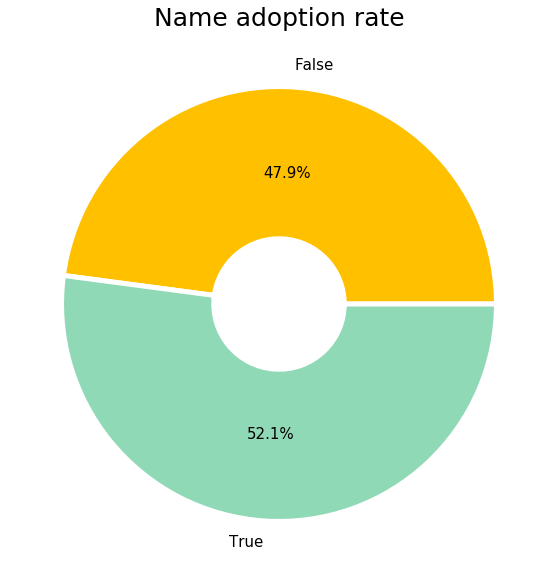

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(train.groupby('cfa_breed')['Adopt'].mean(), labels=['False','True'],  autopct='%.1f%%', 
        colors=['#ffc000','#8fd9b6'],textprops={'size': 15},
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.title('Name adoption rate',fontsize=25)
plt.show()

##### 2 feature

###### Sex 어쩌구/ Years

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


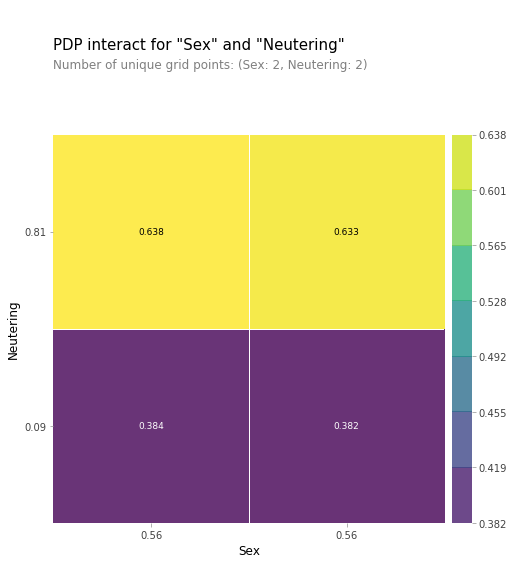

In [ ]:
features = ['Sex', 'Neutering']

interaction = pdp_interact(
    model=rf, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

#### SHAP Value plot

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.8916941529427328, 'randomforestclassifier__min_samples_leaf': 46, 'randomforestclassifier__n_estimators': 513, 'targetencoder__min_samples_leaf': 4, 'targetencoder__smoothing': 100.0}

In [ ]:
# 실제값
y_test.iloc[[1]]

1084    0
Name: Adopt, dtype: int64

In [ ]:
# 모델 예측값

row = X_encoded.iloc[[1]]
pipe.predict(row)

array([1])

In [ ]:
model = pipe.named_steps['randomforestclassifier']

In [ ]:
# 중첩 brackets을 사용하면 결과물이 DataFrame입니다
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1],
    features=row
)

# 0.5593은 기준모델에 의한 ~~ 1일 확률인데 0.8은 row값이 1일 확률

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_encoded.iloc[:1000])

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1],
    features=X_encoded.iloc[:1000]
)

##### bar plot

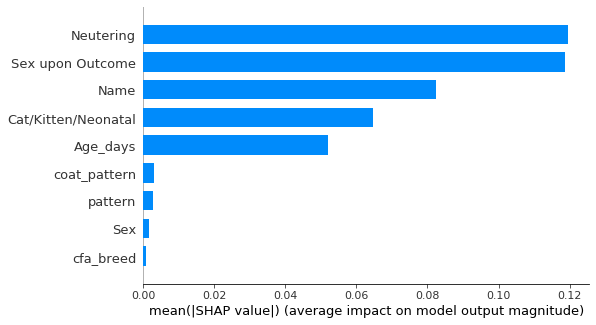

In [ ]:
shap_values = explainer.shap_values(X_encoded.iloc[:300])
shap.summary_plot(shap_values[0],  X_encoded, plot_type='bar')

##### scatter plot

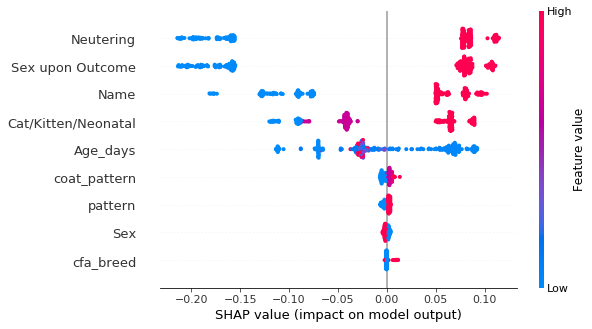

In [ ]:
shap_values = explainer.shap_values(X_encoded.iloc[:300])
shap.summary_plot(shap_values[1],  X_encoded.iloc[:300])

##### violin plot

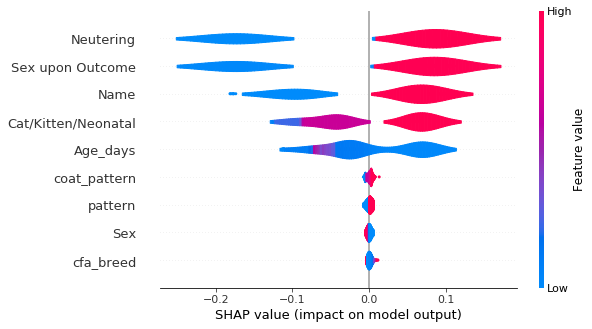

In [ ]:
shap_values = explainer.shap_values(X_encoded.iloc[:300])
shap.summary_plot(shap_values[1],  X_encoded.iloc[:300], plot_type='violin')